In [173]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GOOGLE_API_KEY']=os.getenv("GOOGLE_API_KEY")

In [174]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


### Config the embedding model

In [175]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings= HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

#### Lets data and embedd it and store in the vector database

In [176]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [177]:
docs=DirectoryLoader("../0-Data",glob="./*.txt",loader_cls=TextLoader).load()

In [178]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)

In [179]:
new_docs=text_splitter.split_documents(documents=docs)

In [180]:
new_docs

[Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='innovation, global t

In [181]:
doc_string=[doc.page_content for doc in new_docs]
doc_string

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,',
 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a',
 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.',
 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.',
 'U.S. GDP – Size, Composition, and Global Share',
 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 

#### save in the chroma DB

In [182]:
db=Chroma.from_documents(documents=new_docs,embedding=embeddings)

In [183]:
retriever=db.as_retriever(search_kwargs={"k":3})

In [184]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '..\\DataUSA\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\DataUSA\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\0-Data\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation')]

#### creation of pydantic class

In [185]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [186]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [187]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [188]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

##### messages will keep in appeding the msg . that we can as STATE
###### {'messages':[
    'hi how are you?',
    'what are you doing?',
    'how is your day?'
]}

In [189]:
def fun_supervisor(state:AgentState):
    question=state["messages"][-1]

    print("Your question is : ", question)

    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    promt=PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )

    chain=promt|model|parser

    response=chain.invoke({"question":question})
    print("Parsed response:", response)
    return {"messages":[response.Topic]}


In [190]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [191]:
def fun_RAG(state:AgentState):
    print("=> RAG Call=>")

    question=state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain=(
        {"context": retriever | format_docs, "question":RunnablePassthrough()}
         |prompt|model|StrOutputParser()
    )
    result=rag_chain.invoke(question)
    return {"messages":[result]}


In [192]:
def fun_LLM(state:AgentState):
    print("=> LLM Call=>")

    question=state["messages"][0]

    query="Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response=model.invoke(query)
    return {"messages":[response.content]}

In [193]:
def router(state:AgentState):
    print("=> Router =>")

    last_msg=state['messages'][-1]
    print("last message: ", last_msg)

    if "usa" in last_msg.lower():
        return "RAG Call"
    else:
        return "LLM Call"

#### Create the STATE graph, this is not simple graph it is state graph

In [194]:
from langgraph.graph import StateGraph, END

In [195]:
workflow=StateGraph(AgentState)

In [196]:
workflow.add_node("Supervisor", fun_supervisor)
workflow.add_node("RAG", fun_RAG)
workflow.add_node("LLM", fun_LLM)

In [197]:
workflow.set_entry_point("Supervisor")

In [198]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM"
    }
)

In [199]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

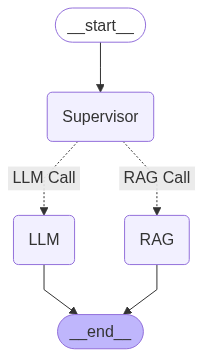

In [200]:
app=workflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [201]:
state={"messages":["vijay here"]}

app.invoke(state)

Your question is :  vijay here
Parsed response: Topic='Not Related' Reasoning='The query "vijay here" does not contain any information related to the USA.'
=> Router =>
last message:  Not Related
=> LLM Call=>


{'messages': ['vijay here',
  'Not Related',
  'Hello Vijay!  How can I help you today?']}

In [202]:
state={"messages":["what is the GDP of Trump president country"]}

app.invoke(state)

Your question is :  what is the GDP of Trump president country
Parsed response: Topic='USA' Reasoning="The query asks about the GDP of Trump's country, which refers to the United States."
=> Router =>
last message:  USA
=> RAG Call=>


{'messages': ['what is the GDP of Trump president country',
  'USA',
  'The provided text only gives the heading "U.S. GDP – Size, Composition, and Global Share" repeated three times.  It does not contain the actual GDP figure.  Therefore, I don\'t know the answer.']}

In [203]:
state={"messages":["what is the GDP of USA"]}

app.invoke(state)

Your question is :  what is the GDP of USA
Parsed response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
=> Router =>
last message:  USA
=> RAG Call=>


{'messages': ['what is the GDP of USA',
  'USA',
  "I don't know the exact current GDP of the USA.  The provided text only gives the title of a potential data source, not the actual GDP figure."]}